In [ ]:
!rm -rf glo-flow

In [ ]:
!git clone https://github.com/AlexanderNevarko/glo-flow.git

Cloning into 'glo-flow'...
remote: Enumerating objects: 244, done.
remote: Counting objects: 100% (244/244), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 244 (delta 141), reused 178 (delta 80), pack-reused 0
Receiving objects: 100% (244/244), 506.74 KiB | 2.63 MiB/s, done.
Resolving deltas: 100% (141/141), done.


In [4]:
import sys
sys.path.append('glo-flow/')
sys.path

['/Users/aleksandr/Desktop/newGAN/glo-flow/notebooks',
 '/Users/aleksandr/miniconda/lib/python38.zip',
 '/Users/aleksandr/miniconda/lib/python3.8',
 '/Users/aleksandr/miniconda/lib/python3.8/lib-dynload',
 '',
 '/Users/aleksandr/miniconda/lib/python3.8/site-packages',
 '/Users/aleksandr/Desktop/hacks/liders/Real-ESRGAN',
 '/Users/aleksandr/miniconda/lib/python3.8/site-packages/IPython/extensions',
 '/Users/aleksandr/.ipython',
 'glo-flow/',
 'glo-flow/']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q comet_ml

In [ ]:
from comet_ml import Experiment
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

BW_METHOD = 0.1
N_COMPONENTS = 32

### Training the model

In [ ]:
# %load_ext autoreload
# %autoreload 2

In [3]:
from modules.glo_generator import GLOGenerator, GLOModel, SampleGenerator
from modules.train import GLOTrainer, visualize_image_grid
from modules.dataset import IdxDataset
from modules.validate import Validator
from modules.loss import LapLoss

ModuleNotFoundError: No module named 'modules'

In [ ]:
mnist_train = MNIST(root='datasets', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = MNIST(root='datasets', train=False, transform=transforms.ToTensor(), download=True)

In [ ]:
mnist_train = IdxDataset(mnist_train)
mnist_test = IdxDataset(mnist_test)

In [ ]:
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=1, pin_memory=True)
sampler_init_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=False)
val_loader = DataLoader(mnist_test, batch_size=32, shuffle=False)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
generator = GLOGenerator(min_channels=16,
                         max_channels=128,
                         noise_channels=N_COMPONENTS,
                         num_blocks=3,
                         dataloader=train_loader,
                         normalization='ada',
                         lrelu_slope=0).to(device)
sample_generator = SampleGenerator(sampler_init_train_loader, z_dim=N_COMPONENTS, bw_method=BW_METHOD)
model = GLOModel(generator, train_loader, sample_generator, sparse=True).to(device)

In [ ]:
experiment = Experiment(api_key='CfFmqDpTCtsdDkLooedZh7bs2',
                        project_name='glo-mnist',
                        workspace='alexandernevarko')

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' and lookings in parents. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/alexandernevarko/glo-mnist/710fae94211a4259946f1d90f630efba



In [ ]:
trainer = GLOTrainer(model, use_gpu=True, logger=experiment)

In [ ]:
zlr = 1e-3
gen_lr = 1e-3
loss_func = LapLoss(max_levels=2, channels=1, device=device)
g_optimizer = torch.optim.Adam(params=model.generator.parameters(), lr=gen_lr)
z_optimizer = torch.optim.SparseAdam(params=model.z.parameters(), lr=zlr)

In [ ]:
n_epochs = 100
trainer.train(n_epochs=n_epochs, train_loader=train_loader, 
              loss_func=loss_func, 
              generator_optimizer=g_optimizer, z_optimizer=z_optimizer,
              exp_name=f'Adam_SparseAdam_z_{N_COMPONENTS}_zlr_1e-3_glr_1e-3_{n_epochs}_epochs', model_path='')

  0%|          | 0/938 [00:00<?, ?it/s]glo-flow/modules/glo.py:157: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.



Average epoch 0 loss: 0.05719688147115809


Average epoch 1 loss: 0.03736641015936889


Average epoch 2 loss: 0.03400549466715756


Average epoch 3 loss: 0.03154529855926154


Average epoch 4 loss: 0.0296944218939905


Average epoch 5 loss: 0.028224508965145678


Average epoch 6 loss: 0.02706743026180054


Average epoch 7 loss: 0.02615528396253329


Average epoch 8 loss: 0.025377045669503558


Average epoch 9 loss: 0.02467691518866749


Average epoch 10 loss: 0.024071343729633893


Average epoch 11 loss: 0.023523348806572874


Average epoch 12 loss: 0.023028912759427703


Average epoch 13 loss: 0.022568832733420165


Average epoch 14 loss: 0.02217742322739571


Average epoch 15 loss: 0.02183245680034796


Average epoch 16 loss: 0.021457723163163613


Average epoch 17 loss: 0.021099948822689462


Average epoch 18 loss: 0.020848916859419614


Average epoch 19 loss: 0.02054688996319641


Average epoch 20 loss: 0.020269816808863236


Average epoch 21 loss: 0.02004754972427702


Average epoch 22 loss: 0.01984339060861546


Average epoch 23 loss: 0.019591620249518833


Average epoch 24 loss: 0.01943275876946922


Average epoch 25 loss: 0.01921332792154571


Average epoch 26 loss: 0.019060233176977776


Average epoch 27 loss: 0.018898481024560262


Average epoch 28 loss: 0.018737225692028174


Average epoch 29 loss: 0.018595148328699664


Average epoch 30 loss: 0.018459318271244387


Average epoch 31 loss: 0.018305477126241365


Average epoch 32 loss: 0.01820046283693901


Average epoch 33 loss: 0.018086143712729597


Average epoch 34 loss: 0.01796917423014162


Average epoch 35 loss: 0.01785890167571112


Average epoch 36 loss: 0.01776655032031381


Average epoch 37 loss: 0.017658229491341788


Average epoch 38 loss: 0.01756067525174445


Average epoch 39 loss: 0.017455521997795112


Average epoch 40 loss: 0.01738751065263997


Average epoch 41 loss: 0.017324268213236956


Average epoch 42 loss: 0.017226099906397906


Average epoch 43 loss: 0.017142246924102433


Average epoch 44 loss: 0.017077340462457524


Average epoch 45 loss: 0.01699846516202476


Average epoch 46 loss: 0.01695253334736932


Average epoch 47 loss: 0.016864036472001943


Average epoch 48 loss: 0.016805497056711267


Average epoch 49 loss: 0.016758284774789616


Average epoch 50 loss: 0.01667631787261856


Average epoch 51 loss: 0.016619330396188667


Average epoch 52 loss: 0.016574126208570402


Average epoch 53 loss: 0.01650957260002841


Average epoch 54 loss: 0.016462371195120406


Average epoch 55 loss: 0.01641156024106943


Average epoch 56 loss: 0.016362045358405755


Average epoch 57 loss: 0.016317927194183377


Average epoch 58 loss: 0.016267022624341793


Average epoch 59 loss: 0.01622082974547262


Average epoch 60 loss: 0.0161793385374187


Average epoch 61 loss: 0.016144008552437143


Average epoch 62 loss: 0.01608187759886863


Average epoch 63 loss: 0.016047952410731234


Average epoch 64 loss: 0.01602614317327611


Average epoch 65 loss: 0.01597780784043962


Average epoch 66 loss: 0.015938098025101145


Average epoch 67 loss: 0.015908891284492795


Average epoch 68 loss: 0.0158744608627946


Average epoch 69 loss: 0.015831351550276093


Average epoch 70 loss: 0.015812378621963996


Average epoch 71 loss: 0.01576845077519764


Average epoch 72 loss: 0.01572833080063147


Average epoch 73 loss: 0.01570002049076627


Average epoch 74 loss: 0.015659175602707274


Average epoch 75 loss: 0.015627157291584114


Average epoch 76 loss: 0.015607823049828315


Average epoch 77 loss: 0.015595343409737608


Average epoch 78 loss: 0.015548629255325937


Average epoch 79 loss: 0.015521151538906512


Average epoch 80 loss: 0.015485303444680628


Average epoch 81 loss: 0.015476489128834849


Average epoch 82 loss: 0.015435116628665469


Average epoch 83 loss: 0.015416389098887378


Average epoch 84 loss: 0.015395650486233455


Average epoch 85 loss: 0.015352790599375138


Average epoch 86 loss: 0.015333348156403758


Average epoch 87 loss: 0.01531980114617645


Average epoch 88 loss: 0.015290425236481848


Average epoch 89 loss: 0.015273986987944351


Average epoch 90 loss: 0.015245563705076478


Average epoch 91 loss: 0.015216538214932945


Average epoch 92 loss: 0.015202129916000022


Average epoch 93 loss: 0.015186634073570085


Average epoch 94 loss: 0.015141787868279067


Average epoch 95 loss: 0.01512246280571005


Average epoch 96 loss: 0.015106578007030653


Average epoch 97 loss: 0.01510589287729501


Average epoch 98 loss: 0.015072719020240787


Average epoch 99 loss: 0.015059497307684185


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/Adam_SparseAdam_z_32_zlr_1e-3_glr_1e-3_100_epochs_model.pth /content/drive/MyDrive/GLANN/glo_mnist_models/SOTA_Adam_SparseAdam_z_32_zlr_1e-3_glr_1e-3_100_epochs_model.pth

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/GLANN/glo_mnist_models/SOTA_Adam_SparseAdam_z_32_zlr_1e-3_glr_1e-3_100_epochs_model.pth'))

<All keys matched successfully>

In [ ]:
z = nn.Parameter(torch.randn(size=(len(val_loader.dataset), N_COMPONENTS), device=device, requires_grad=True))
optimizer = torch.optim.SGD([z], lr=5e1)
loss_func = LapLoss(max_levels=2, channels=1, device=device)

validator = Validator(model, val_loader)

In [ ]:
z_new, loss = validator.validate(z=z, min_loss=0.02, max_iter=60, loss_func=loss_func, optimizer=optimizer)

  0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.



In [ ]:
loss

0.04884654502518261

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.



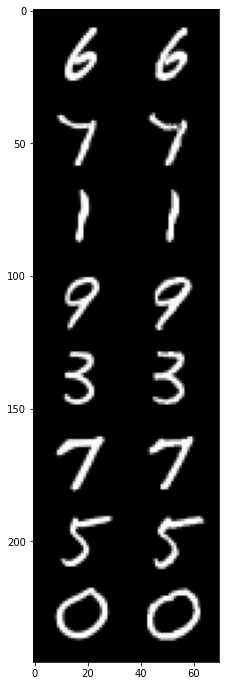

In [ ]:
idx = torch.randint(low=0, high=len(z), size=(8, ))
img = []
for i in idx:
    img.append(val_loader.dataset[i][1])
img = torch.cat(img).view(8, 1, 28, 28)
res = validator.visualize_val_results(z=z_new[idx], img=img)
plt.figure(figsize=(18, 12))
plt.imshow(res)
plt.savefig('mnist_val_3.png')

In [ ]:
img.shape

torch.Size([8, 1, 28, 28])

In [ ]:
!rm -rf glo-flow

Now let's look at the model Z distribution!

In [ ]:
z_numpy = model.z.weight.detach().cpu().numpy()

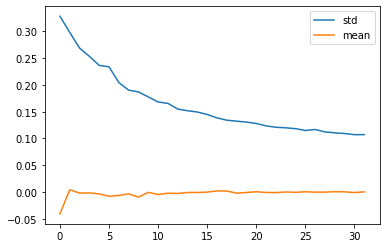

In [ ]:
plt.plot(z_numpy.std(axis=0), label='std')
plt.plot(z_numpy.mean(axis=0), label='mean')
plt.legend()

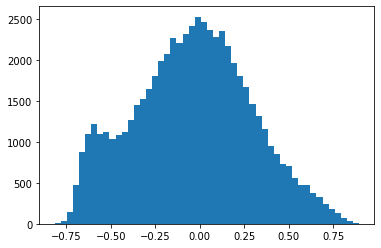

In [ ]:
_ = plt.hist(z_numpy[:, 0], bins=50)

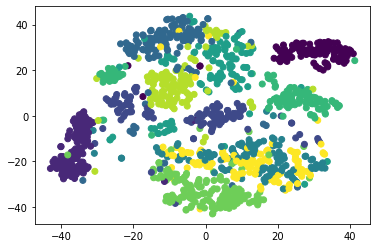

In [ ]:
z_pca = sample_generator.z_dataset[::50, :]
cmap = sample_generator.get_classes()[::50]
X_embedded = TSNE(n_components=2).fit_transform(z_pca)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=cmap)

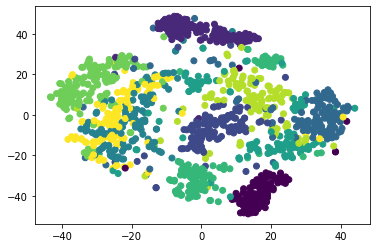

In [ ]:
z_model = model.z.weight[::50, :].detach().cpu().numpy()
X_embedded = TSNE(n_components=2).fit_transform(z_model)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=cmap)

In [ ]:
a = torch.tensor([1, 2, 3])
b = torch.tensor([0, 3, 5])
torch.amax(torch.vstack([a, b]), dim=0)

tensor([1, 3, 5])

In [ ]:
a.long()

tensor([1, 2, 3])

In [ ]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/alexandernevarko/glo-mnist/e6cdd673a6a445f4b96988585c9e0e6e
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Average epoch train loss [25] : (0.06706139348546664, 0.19293082938989004)
COMET INFO:     Train loss [46875]            : (0.053143858909606934, 0.24696052074432373)
COMET INFO:     loss [5266]                   : (0.053791023790836334, 0.26565197110176086)
COMET INFO:   Others:
COMET INFO:     Name : LapL1_z_128_zlr_1e2_25_epochs
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     images              : 25
COMET INFO:     installed packages  : 1
COMET INFO:     model graph         : 1
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
C